In [1]:
# common imports
import os
import numpy as np
import datetime
import time
import matplotlib.pylab as plt
import pandas as pd
from glob import glob
from pathlib import Path
from functools import partial
#import plotly.express as px

from sklearn.model_selection import train_test_split

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
# prevent VRAM occupied
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# load tensorboard extension
%reload_ext tensorboard

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
# Constants
SEED =42
# minimum number of cases for each diagnosis/finding label (of 14)
MIN_CASES  = 1000
MIN_CASES_FLAG = True
IMAGE_SIZE = (224,224)
IMAGE_SHAPE = (224,224,3)
BATCH_SIZE = 32
SHUFFLE = True
TARGET_WIDTH= 224
TARGET_HEGIHT =224
NUM_CLASSES = 14 # number of ClassesNUM
NUM_EPOCHS = 2
#PRETRAINED_MODELS = ['ResNet50V2', 'MobileNetV2', 'VGG16', 'InceptionV3' ,'DenseNet121'] # pretrained modelspretrained_models = ['ResNet50V2', 'MobileNetV2', 'VGG16', 'InceptionV3'] # pretrained modelspr
PRETRAINED_MODELS = ['ResNet50V2']
log_folder = 'logs' # logs folder

In [3]:
nih_xrays_df = pd.read_csv('../data/processed/prepared_data_entry_2017.csv')

In [4]:
nih_xrays_df.describe()

,patient_id
count,91202.000000
mean,14183.895803
std,8448.550723
min,1.000000
25%,7034.000000
50%,13737.000000
75%,20624.000000
max,30805.000000


In [5]:
# Get fourteen unique diagnosis
# It is a function that takes a series of iterables and returns one iterable
# The asterisk "*" is used in Python to define a variable number of arguments. 
# The asterisk character has to precede a variable identifier in the parameter list 
from itertools import chain
all_labels = np.unique(list(chain(*nih_xrays_df['finding_label'].map(lambda x: x.split('|')).tolist())))
# remove the empty label
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Infiltration', 'Mass', 'NoFinding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [6]:
nih_xrays_train_df = pd.read_csv('../data/processed/prepared_train_data_entry_2017.csv')
nih_xrays_valid_df = pd.read_csv('../data/processed/prepared_valid_data_entry_2017.csv')

In [7]:
nih_xrays_train_df['path'] = nih_xrays_train_df['path'].map(lambda x: '../' +x) 
nih_xrays_valid_df['path'] = nih_xrays_valid_df['path'].map(lambda x: '../' +x) 

In [8]:
nih_xrays_train_df[['path']].head(10)

,path
0,../data/raw/nih/images_001/images/00000001_000...
1,../data/raw/nih/images_001/images/00000002_000...
2,../data/raw/nih/images_001/images/00000005_000...
3,../data/raw/nih/images_001/images/00000005_001...
4,../data/raw/nih/images_001/images/00000005_002...
5,../data/raw/nih/images_001/images/00000005_003...
6,../data/raw/nih/images_001/images/00000005_004...
7,../data/raw/nih/images_001/images/00000005_005...
8,../data/raw/nih/images_001/images/00000005_006...
9,../data/raw/nih/images_001/images/00000007_000...


In [9]:
from keras.applications.resnet_v2 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
image_data_gen = ImageDataGenerator(
    preprocessing_function= preprocess_input,
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=True, #Boolean. Set each sample mean to 0.
    samplewise_std_normalization = False, #Boolean. Divide each input by its std.
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    horizontal_flip = True, #Boolean. Randomly flip inputs horizontally.
    vertical_flip = False,  #Boolean. Randomly flip inputs vertically.
    zca_whitening=False,  # apply ZCA whitening
    height_shift_range= 0.05, #float: fraction of total height, if < 1, or pixels if >= 1.
    width_shift_range=0.1,  #float: fraction of total height, if < 1, or pixels if >= 1.
    rotation_range=20, #Int. Degree range for random rotations. 0 -180 degrees
    shear_range = 0.1, #Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    fill_mode = 'nearest', #One of {"constant", "nearest", "reflect" or "wrap"}. Default is 'nearest'. 
    zoom_range=0.15) #Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range]

In [10]:
#Takes the dataframe and the path to a directory + generates batches.
train_generator = image_data_gen.flow_from_dataframe(
            dataframe=nih_xrays_train_df,
            directory=None, #string, path to the directory to read images from. 
                            #If None, data in x_col column should be absolute paths.
            x_col='path', #string, column in dataframe that contains the filenames (or absolute paths if directory is None).
            y_col='finding_label', #string or list, column/s in dataframe that has the target data.
    
            class_mode="categorical", #one of "binary", "categorical", "input", "multi_output", "raw", sparse" or None. Default: "categorical". 
                              # Mode for yielding the targets: "raw": numpy array of values in y_col column(s),
            classes=all_labels,
            #color_mode='grayscale',
            batch_size=BATCH_SIZE,
            shuffle=SHUFFLE,
            seed=SEED,
            target_size= IMAGE_SIZE)

#Takes the dataframe and the path to a directory + generates batches.
valid_generator = image_data_gen.flow_from_dataframe(
            dataframe=nih_xrays_valid_df,
            directory=None, #string, path to the directory to read images from. 
                            #If None, data in x_col column should be absolute paths.
            x_col='path', #string, column in dataframe that contains the filenames (or absolute paths if directory is None).
            y_col='finding_label', #string or list, column/s in dataframe that has the target data.
    
            class_mode="categorical", #one of "binary", "categorical", "input", "multi_output", "raw", sparse" or None. Default: "categorical". 
                              # Mode for yielding the targets: "raw": numpy array of values in y_col column(s),
            classes=all_labels,
            #color_mode='grayscale',
            batch_size=BATCH_SIZE,
            shuffle=SHUFFLE,
            seed=SEED,
            target_size= IMAGE_SIZE)
test_X, test_Y = next(image_data_gen.flow_from_dataframe( nih_xrays_valid_df,
                            directory = None,    
                            x_col = 'path',
                            y_col = 'finding_label', 
                            seed =42,
                            target_size = IMAGE_SIZE,
                            class_mode='categorical',
                            #classes = all_labels,
                            #save_to_dir='../data/interm/test',
                            #validation =0.2,
                            #color_mode = 'grayscale',
                            batch_size = 32)) # one big batch

Found 72862 validated image filenames belonging to 14 classes.
Found 18340 validated image filenames belonging to 14 classes.
Found 18340 validated image filenames belonging to 14 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


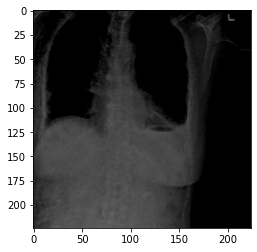

In [11]:
x, y = train_generator.__getitem__(2)
plt.imshow(x[0])
print(y[0])

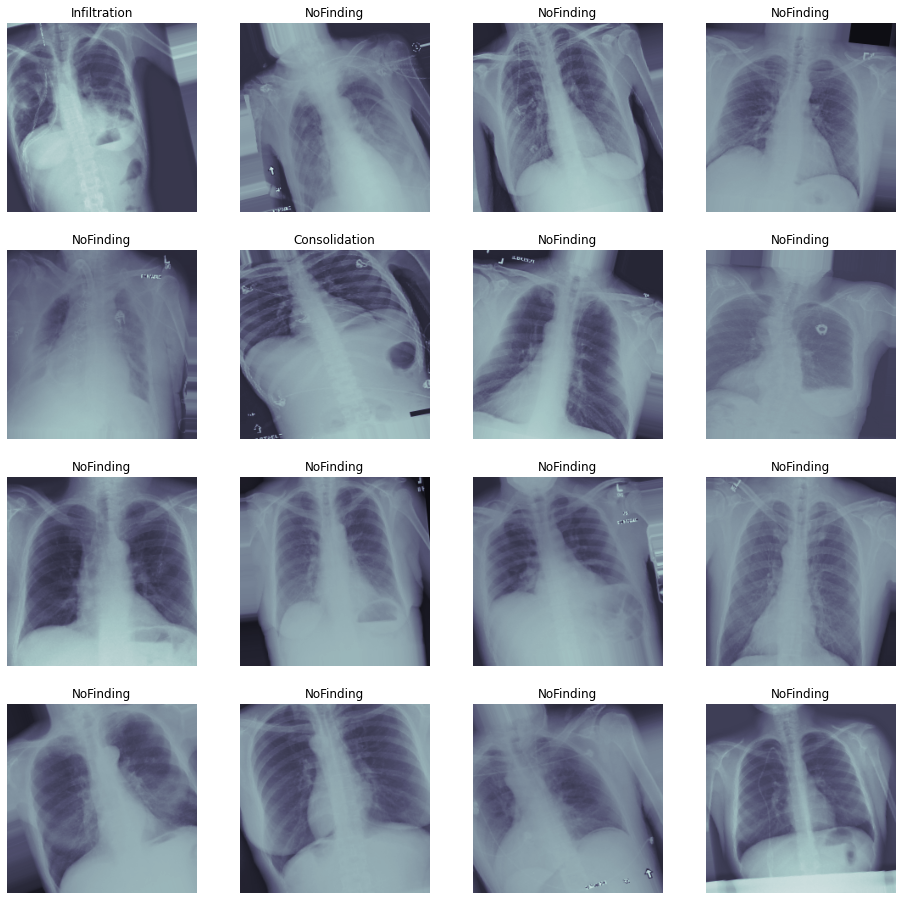

In [12]:
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

In [13]:
def get_base_model(model_name :str = 'resenet50v2', freeze_layers:bool = False):
    """ returns pretrained model

    Args:
        model_name (str): model_name values pretrained_models = ['ResNet50V2', 'MobileNetV2', 'VGG16']
    """
    if model_name == 'ResNet50V2' :
        print(f"Downloading ResNet50V2")
        base_model = tf.keras.applications.ResNet50V2(input_shape=IMAGE_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
    elif model_name == 'MobileNetV2' :
        print(f"Downloading MobileNetV2")
        base_model = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
    elif model_name == 'VGG16' :
        print(f"Downloading VGG16")
        base_model = tf.keras.applications.VGG16(input_shape=IMAGE_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
    elif model_name == 'DenseNet121' :
        print(f"Downloading DenseNet121")
        base_model = tf.keras.applications.DenseNet121(input_shape=None,
                                                      input_tensor=None,
                                               include_top=False,
                                               weights='imagenet')
    if freeze_layers == True:
        for layer in base_model.layers:
            layer.trainable = False
            #assert layer.trainable is False
    
    return base_model


def compile_classifier(model, learning_rate, optimizer = 'Adam'):
    """[summary]

    Args:
        model ([tensorflow.keras.Model]): classifier model
        learning_rate ([float]): [description]
        optimizer ([tensorflow.keras.optimizers]): optimizer
    """
    if optimizer == 'Adam':
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=learning_rate,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-07,
            amsgrad=True,
            name="Adam"
            )

    elif optimizer == 'Adagrad':
        optimizer=tf.keras.optimizers.Adagrad(
            learning_rate=learning_rate,
            initial_accumulator_value=0.1,
            epsilon=1e-07,
            name="Adagrad")
    
    elif optimizer == 'NestrovSGD':
        optimizer=tf.keras.optimizers.SGD(
            learning_rate=0.01, 
            momentum=0.9, 
            nesterov=True, 
            name="SGD")

    
    model.compile(optimizer = optimizer,
                  #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  #loss =tf.keras.losses.CategoricalCrossentropy(),
                  #loss=get_weighted_loss(pos_weights, neg_weights),
                  #metrics=['accuracy']
                  loss = tf.keras.losses.binary_crossentropy,
                  #metrics =['binary_accuracy', 'mae', 'auc']
                  metrics = [keras.metrics.MAE, 
                             keras.metrics.AUC(name='auc',multi_label=True),
                             keras.metrics.BinaryAccuracy(threshold=0.65),
                             keras.metrics.FalseNegatives(),
                             keras.metrics.FalsePositives(), 
                             ]
                  )
    
    return model

def get_base_model_with_new_toplayer(base_model, 
                                     freeze_layers: bool = False, 
                                     num_classes: int = NUM_CLASSES,
                                     learning_rate: float = 0.01):
    """ add a classifier

    Args:
        base_model ([keras.Model]): base_model
        num_classes ([int]) : number classes
    """
    base_model = get_base_model(base_model,freeze_layers)
    head_model = base_model.output
    head_model = keras.layers.Flatten(name="flatten")(head_model)
    # head_model = keras.layers.Dense(256, activation="relu")(head_model)
    # head_model = keras.layers.Dropout(0.3)(head_model)
    # head_model = keras.layers.Dense(128, activation="relu")(head_model)
    # head_model = keras.layers.Dropout(0.3)(head_model)
    # head_model = keras.layers.Dense(64, activation="relu")(head_model)
    head_model = keras.layers.Dense(num_classes,activation='sigmoid')(head_model)
    model = keras.Model(inputs=base_model.input, outputs=head_model)
    model = compile_classifier(model, learning_rate)
    return model



def fine_tune_model(model, learning_rate =0.00001, optimizer = 'Adam',  fine_tune_at_layer:int=100):
    # Freeze all the layers before the `fine_tune_at` layer
    for layer in model.layers[fine_tune_at_layer:]:
        layer.trainable =  True
    compile_classifier(model, learning_rate = learning_rate, optimizer=optimizer)
    return model

#callback setup
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

checkpoint_path = '../models/xray_class_weights.best.hdf5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", min_delta = 1e-4, patience = 5, mode = 'min', 
                    restore_best_weights = True, verbose = 1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience = 2, verbose = 1, 
                                min_delta = 1e-4, min_lr = 1e-6, mode = 'min', cooldown=1)

callbacks = [checkpoint, early, reduce_lr]



def fit_model(model,train_ds,
    validation_ds, 
    num_epochs: int = NUM_EPOCHS, batch_size: int = BATCH_SIZE):
    history = model.fit(train_ds,
                    epochs=num_epochs,
                    validation_data=validation_ds,
                    steps_per_epoch = len(train_ds)//batch_size,#steps_per_epoch = 100, 
                    validation_steps=len(validation_ds)//batch_size, #validation_steps= 25, 
                    callbacks=callbacks)
    return history

def plot_epocs_vs_val_loss(history):
    plt.figure(figsize = (12, 6))
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot( history.history["loss"], label = "Training Loss", marker='o')
    plt.plot( history.history["val_loss"], label = "Validation Loss", marker='+')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_epocs_vs_auc(history):
    plt.figure(figsize = (12, 6))
    plt.xlabel("Epochs")
    plt.ylabel("AUC")
    plt.plot( history.history["auc"], label = "Training AUC" , marker='o')
    plt.plot( history.history["val_auc"], label = "Validation AUC", marker='+')
    plt.grid(True)
    plt.legend()
    plt.show()

def train_validate_classifier(model_name, train_generator, valid_generator, learning_rate:float = 0.0001, fine_tune_at_layer:int = 100):
    
    
    model = get_base_model_with_new_toplayer(model_name,freeze_layers = False,
        num_classes = NUM_CLASSES)

    
    print("\n")
    print(f'{model_name} Training and Validation: ')
    
    history = fit_model(model, train_generator, 
        valid_generator, 
        num_epochs=NUM_EPOCHS)

    print(f'{model_name} Accuracy and Loss plots')
    plot_epocs_vs_val_loss(history)
    plot_epocs_vs_auc(history)
    
    print("\n")
    #fine_tune model_name
    model_ft = fine_tune_model(model,learning_rate,optimizer='Adam',fine_tune_at_layer=fine_tune_at_layer)
    #print(model_ft.summary())

    
    print("\n")
    print(f'Fine-Tuned {model_name} Training and Validation: ')
    history_fine = fit_model(model_ft, train_generator, 
        valid_generator, 
        num_epochs=NUM_EPOCHS)
    print(f'Fine-Tuned {model_name} Accuracy and Loss plots')
    plot_epocs_vs_val_loss(history_fine)
    plot_epocs_vs_auc(history_fine)
    model_ft.save('../models/my-model')


In [15]:


pretrained_base_model = PRETRAINED_MODELS[0]
learning_rate = 0.001
fine_tune_at_layer = 178
train_validate_classifier(pretrained_base_model,train_generator, valid_generator, learning_rate,fine_tune_at_layer)

InvalidArgumentError: Node 'training/Adam/gradients/gradients/post_bn/cond_grad/StatelessIf': Connecting to invalid output 3 of source node post_bn/cond which has 3 outputs. Try using tf.compat.v1.experimental.output_all_intermediates(True).

# Phase II -  Reload the Saved Model and Train, Validate and test on new Covid19 dataset

In [ ]:
# Reload the model weights
#pretrained_base_model = PRETRAINED_MODELS[0]
print(os.getcwd())
# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("../models/my-model")

/home/jay/Temple/myprojects/covid19-image-detection-tfl/notebooks


In [ ]:
new_layer = reconstructed_model.layers[-2].output
output = keras.layers.Dense(3, activation='softmax')(new_layer)
new_model = keras.Model(inputs = reconstructed_model.input, outputs = output)

In [ ]:
new_model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_15[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
BATCH_SIZE =1

covid_image_train_data_gen = ImageDataGenerator(
    preprocessing_function= preprocess_input,
    validation_split=0.2,
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=True, #Boolean. Set each sample mean to 0.
    samplewise_std_normalization = False, #Boolean. Divide each input by its std.
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    horizontal_flip = True, #Boolean. Randomly flip inputs horizontally.
    vertical_flip = False,  #Boolean. Randomly flip inputs vertically.
    zca_whitening=False,  # apply ZCA whitening
    height_shift_range= 0.05, #float: fraction of total height, if < 1, or pixels if >= 1.
    width_shift_range=0.1,  #float: fraction of total height, if < 1, or pixels if >= 1.
    rotation_range=20, #Int. Degree range for random rotations. 0 -180 degrees
    shear_range = 0.1, #Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    fill_mode = 'nearest', #One of {"constant", "nearest", "reflect" or "wrap"}. Default is 'nearest'. 
    zoom_range=0.15) #Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range]


covid_image_test_data_gen = ImageDataGenerator(
    preprocessing_function= preprocess_input,
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=True, #Boolean. Set each sample mean to 0.
    samplewise_std_normalization = False, #Boolean. Divide each input by its std.
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    horizontal_flip = True, #Boolean. Randomly flip inputs horizontally.
    vertical_flip = False,  #Boolean. Randomly flip inputs vertically.
    zca_whitening=False,  # apply ZCA whitening
    height_shift_range= 0.05, #float: fraction of total height, if < 1, or pixels if >= 1.
    width_shift_range=0.1,  #float: fraction of total height, if < 1, or pixels if >= 1.
    rotation_range=20, #Int. Degree range for random rotations. 0 -180 degrees
    shear_range = 0.1, #Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    fill_mode = 'nearest', #One of {"constant", "nearest", "reflect" or "wrap"}. Default is 'nearest'. 
    zoom_range=0.15) #Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range]




covid_train_generator = covid_image_train_data_gen.flow_from_directory(
  '../data/raw/Covid19-dataset/train',
  subset="training",
  class_mode='categorical',
  classes=['Covid', 'Normal', 'Viral Pneumonia'],
  seed=SEED,
  target_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

covid_valid_generator = covid_image_train_data_gen.flow_from_directory(
  '../data/raw/Covid19-dataset/train/',
  subset="validation",
  classes=['Covid', 'Normal', 'Viral Pneumonia'],
  class_mode='categorical',
  seed=SEED,
  target_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

covid_test_generator = covid_image_test_data_gen.flow_from_directory(
  '../data/raw/Covid19-dataset/test/',
  class_mode='categorical',
  classes=['Covid', 'Normal', 'Viral Pneumonia'],
  seed=SEED,
  target_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

Found 0 images belonging to 3 classes.
Found 0 images belonging to 3 classes.
Found 0 images belonging to 3 classes.


In [ ]:
def train_validate_test_classifier(model, train_generator, valid_generator, learning_rate:float = 0.0001, fine_tune_at_layer:int = 100):
    
   
    model = compile_classifier(model, learning_rate)
    #print(model.summary())
    
    print("\n")
    print(f'Training and Validation: ')
    
    history = fit_model(model, train_generator, 
        valid_generator, 
        num_epochs=NUM_EPOCHS)

    
    print(f'Accuracy and Loss plots')
    plot_epocs_vs_val_loss(history)
    plot_epocs_vs_auc(history)
    
    #evaluate  model
        
    
    print("\n")
    #fine_tune model_name
    model_ft = fine_tune_model(model,learning_rate,optimizer='Adam',fine_tune_at_layer=fine_tune_at_layer)
    #print(model_ft.summary())

    
    print("\n")
    print(f'Fine-Tuned Training and Validation: ')
    history_fine = fit_model(model_ft, train_generator, 
        valid_generator, 
        num_epochs=NUM_EPOCHS)
    print(f'Fine-Tuned Accuracy and Loss plots')
    plot_epocs_vs_val_loss(history_fine)
    plot_epocs_vs_auc(history_fine)
    
    print("\n")

    #evaluate  model
    
    return model_ft



Training and Validation: 
Epoch 1/2
6/6 [==============================] - 6s 360ms/step - loss: 0.8824 - mean_absolute_error: 0.4907 - auc: 0.1435 - binary_accuracy: 0.6111 - false_negatives_31: 5.0000 - false_positives_31: 3.0000 - val_loss: 0.6961 - val_mean_absolute_error: 0.4486 - val_auc: 0.0000e+00 - val_binary_accuracy: 0.6667 - val_false_negatives_31: 1.0000 - val_false_positives_31: 0.0000e+00

Epoch 00001: val_loss did not improve from 0.00003
Epoch 2/2
6/6 [==============================] - 1s 223ms/step - loss: 0.5818 - mean_absolute_error: 0.3290 - auc: 0.8472 - binary_accuracy: 0.7778 - false_negatives_31: 2.0000 - false_positives_31: 2.0000 - val_loss: 0.6868 - val_mean_absolute_error: 0.4425 - val_auc: 0.0000e+00 - val_binary_accuracy: 0.6667 - val_false_negatives_31: 1.0000 - val_false_positives_31: 0.0000e+00

Epoch 00002: val_loss did not improve from 0.00003
Accuracy and Loss plots


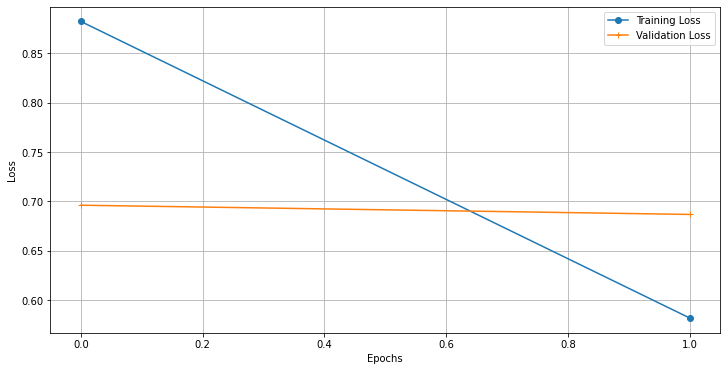

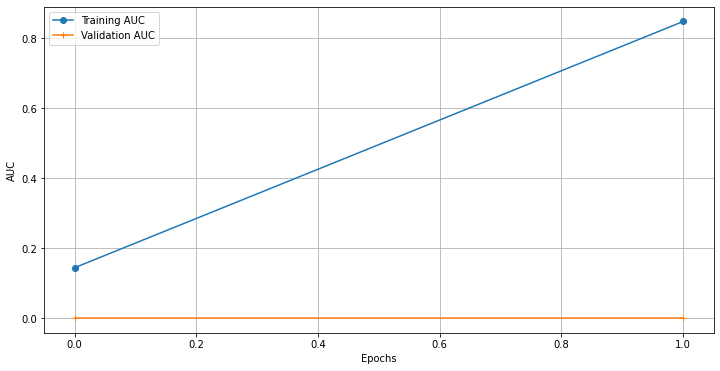





Fine-Tuned Training and Validation: 
Epoch 1/2
6/6 [==============================] - 6s 501ms/step - loss: 0.9563 - mean_absolute_error: 0.4753 - auc: 0.3407 - binary_accuracy: 0.6111 - false_negatives_32: 5.0000 - false_positives_32: 3.0000 - val_loss: 0.6866 - val_mean_absolute_error: 0.4417 - val_auc: 0.0000e+00 - val_binary_accuracy: 0.6667 - val_false_negatives_32: 1.0000 - val_false_positives_32: 0.0000e+00

Epoch 00001: val_loss did not improve from 0.00003
Epoch 2/2
6/6 [==============================] - 1s 257ms/step - loss: 0.8484 - mean_absolute_error: 0.2244 - auc: 0.5000 - binary_accuracy: 0.7778 - false_negatives_32: 2.0000 - false_positives_32: 2.0000 - val_loss: 0.0000e+00 - val_mean_absolute_error: 0.0000e+00 - val_auc: 0.0000e+00 - val_binary_accuracy: 1.0000 - val_false_negatives_32: 0.0000e+00 - val_false_positives_32: 0.0000e+00

Epoch 00002: val_loss improved from 0.00003 to 0.00000, saving model to ../models/xray_class_weights.best.hdf5
Fine-Tuned Accuracy a

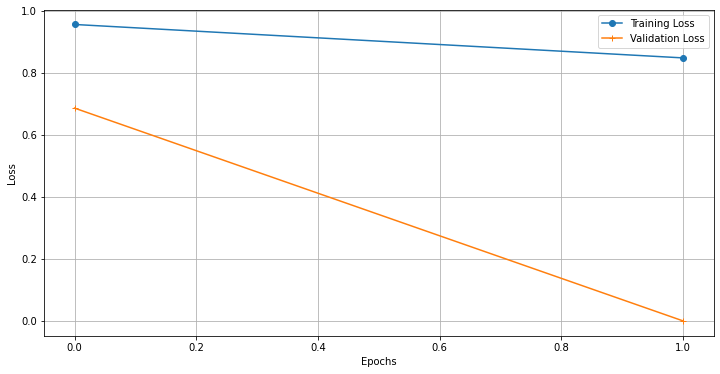

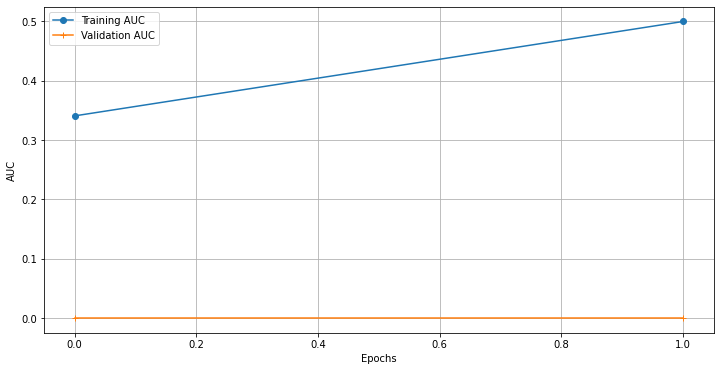

In [ ]:
fine_tune_at_layer = 178
model_ft = train_validate_test_classifier(new_model,
                          covid_train_generator, 
                          covid_valid_generator, 
                          learning_rate,
                          fine_tune_at_layer)

In [ ]:
covid_test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype=int32)

In [ ]:
from sklearn.metrics import roc_auc_score


pred= model_ft.predict(covid_test_generator), verbose=1)

print('AUC CKECK-UP per CLASS')

classes= covid_test_generator.classes
for i, n in enumerate(classes):
  print(classes[i])
  print(i, roc_auc_score(classes[:, i], pred[:, i]))
  print('---------')


SyntaxError: cannot assign to function call (3770720661.py, line 4)